In [10]:
"""
notebook designed to create compiled radar figures for pubs

### psuedocode ###
1. read in list of radar profiles
2. get full path to profiles
3. ingest and pull proc array, lon, lat, elev
4. convert x,y,z to utm coords
5. use pyvista to display profiles in 3d

BST 08OCT2020
py3 env
"""
### impots ###
import sys, os, itertools, glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import plotly.graph_objects as go
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
from scipy.interpolate import griddata
import rasterio as rio
import pyproj

# go up to access NOSEpick modules
sys.path.append("C:/Users/btober/OneDrive - University of Arizona/Documents/code/radar/ragu/code")
from ingest import ingest
from tools import utils
%matplotlib inline
plt.rcParams['figure.figsize'] = [6.5, 6]
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
dpath = "C:/Users/btober/OneDrive - University of Arizona/Documents/data/radar/testdata/ares/"

track = "IRARES1B_20190928-235534.h5"

fpath = dpath + track
print(os.path.isfile(fpath))

True


In [4]:
# ingest radar data
igst = ingest(fpath)
rdata = igst.read("", navcrs="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs", body="earth")

----------------------------------------
Loading: IRARES1B_20190928-235534


In [5]:
# import picks
pk_file = "C:/Users/btober/OneDrive - University of Arizona/Documents/data/radar/IRARES1B/pick/" + track.rstrip(".h5") + "_pk_bst.csv"
print(os.path.isfile(pk_file))
igst.import_pick(pk_file, "bst")

True


['bed_imported']

In [6]:
srf_samps = rdata.pick.horizons["srf"]
bed_samps = rdata.pick.horizons["bed_imported"]

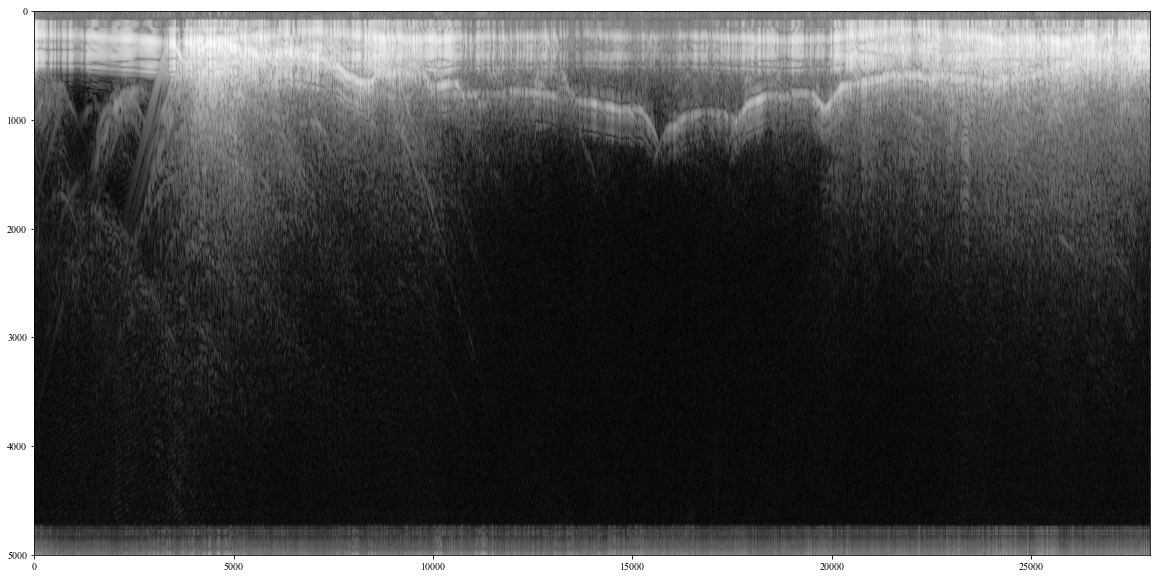

In [7]:
# plotting time
# first, take a quick look at rgram to get an idea of zoomed extent preference to set in next cell
cmap = "Greys_r"
vdmin = np.floor(np.nanpercentile(rdata.proc.get_curr_dB(),10))
vdmax = np.nanmax(rdata.proc.get_curr_dB())
vsmin = np.floor(np.nanpercentile(rdata.sim,10))
vsmax = np.nanmax(rdata.sim)
extent = [0, rdata.tnum, rdata.snum, 0]
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(rdata.proc.get_curr_dB(), aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)

In [8]:
# plotting parameters - set zoomed extent preferences based on figure above
tl = 2500  # left trace
tr = rdata.tnum   # right trace
sb = 1500   # bottom sample
st = 0   # top sample
y_depth_s0 = 150    # sample number to set as zero-depth
extent = [-tl, tr-tl, rdata.snum, 0]

-69.0 28.01081235420766


(1500.0, 0.0)

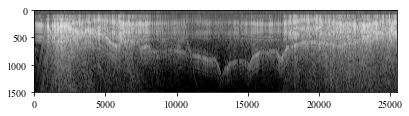

In [242]:
# check what figure will look like at specified zoom extent and adjust clim vmin, vmax if necessary
fig, ax = plt.subplots(figsize=(6.5,1.5))
vdmin = np.floor(np.nanpercentile(rdata.proc.get_curr_dB(),10))
vdmax = np.nanmax(rdata.proc.get_curr_dB())
print(vdmin,vdmax)
vdmin=-60
vdmax=50
ax.imshow(rdata.proc.get_curr_dB(), aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)
ax.set_xlim(0, tr-tl)
ax.set_ylim(sb, st)

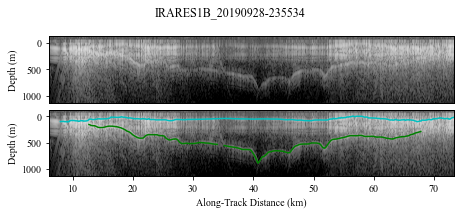

In [98]:
# plot 
fig, ax = plt.subplots(2, figsize=(6.5,3))
fig.suptitle(track.rstrip(".h5"))

ax[0].imshow(rdata.proc.get_curr_dB(), aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)
ax[0].set_xlim(tl, tr)
ax[0].set_ylim(sb, st)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
secaxy = ax[0].twinx()
secaxy.yaxis.set_ticks_position("left")
secaxy.yaxis.set_label_position("left")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])
secaxx = ax[0].twiny()
secaxx.xaxis.set_ticks_position("bottom")
secaxx.xaxis.set_label_position("bottom")
secaxx.set_xlim(rdata.navdf["dist"].iloc[tl-1]*1e-3, rdata.navdf["dist"].iloc[tr-1]*1e-3)
secaxx.get_xaxis().set_visible(False)

ax[1].imshow(rdata.proc.get_curr_dB(),  aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)
ax[1].set_xlim(tl, tr)
ax[1].set_ylim(sb, st)
ax[1].plot(srf_samps,'c')
ax[1].plot(bed_samps,'g')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
secaxy = ax[1].twinx()
secaxy.yaxis.set_ticks_position("left")
secaxy.yaxis.set_label_position("left")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])
secaxx = ax[1].twiny()
secaxx.xaxis.set_ticks_position("bottom")
secaxx.xaxis.set_label_position("bottom")
secaxx.set_xlim(rdata.navdf["dist"].iloc[tl-1]*1e-3, rdata.navdf["dist"].iloc[tr-1]*1e-3)
secaxx.set_xlabel("Along-Track Distance (km)")

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)

In [99]:
fig.savefig('C:/Users/btober/OneDrive - University of Arizona/Documents/pres/mala/figs/2021/' + track.rstrip('.h5') + '.png', dpi=300)

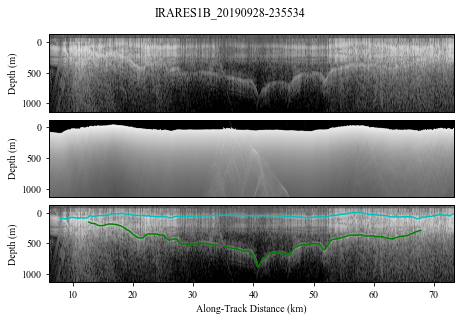

In [104]:
# plot with clutter sim
fig, ax = plt.subplots(3, figsize=(6.5,4.5))
fig.suptitle(track.rstrip(".h5"))

ax[0].imshow(rdata.proc.get_curr_dB(), aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)
ax[0].set_xlim(tl, tr)
ax[0].set_ylim(sb, st)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
secaxy = ax[0].twinx()
secaxy.yaxis.set_ticks_position("left")
secaxy.yaxis.set_label_position("left")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])
secaxx = ax[0].twiny()
secaxx.xaxis.set_ticks_position("bottom")
secaxx.xaxis.set_label_position("bottom")
secaxx.set_xlim(rdata.navdf["dist"].iloc[tl-1]*1e-3, rdata.navdf["dist"].iloc[tr-1]*1e-3)
secaxx.get_xaxis().set_visible(False)

ax[1].imshow(rdata.sim,  aspect="auto", extent=extent, cmap=cmap, vmin=vsmin, vmax=vsmax)
ax[1].set_xlim(tl, tr)
ax[1].set_ylim(sb, st)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
secaxy = ax[1].twinx()
secaxy.yaxis.set_ticks_position("left")
secaxy.yaxis.set_label_position("left")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])
secaxx = ax[1].twiny()
secaxx.xaxis.set_ticks_position("bottom")
secaxx.xaxis.set_label_position("bottom")
secaxx.set_xlim(rdata.navdf["dist"].iloc[tl-1]*1e-3, rdata.navdf["dist"].iloc[tr-1]*1e-3)
secaxx.get_xaxis().set_visible(False)

ax[2].imshow(rdata.proc.get_curr_dB(),  aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)
ax[2].set_xlim(tl, tr)
ax[2].set_ylim(sb, st)
ax[2].plot(srf_samps,'c')
ax[2].plot(bed_samps,'g')
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
secaxy = ax[2].twinx()
secaxy.yaxis.set_ticks_position("left")
secaxy.yaxis.set_label_position("left")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])
secaxx = ax[2].twiny()
secaxx.xaxis.set_ticks_position("bottom")
secaxx.xaxis.set_label_position("bottom")
secaxx.set_xlim(rdata.navdf["dist"].iloc[tl-1]*1e-3, rdata.navdf["dist"].iloc[tr-1]*1e-3)
secaxx.set_xlabel("Along-Track Distance (km)")

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)

In [103]:
fig.savefig('C:/Users/btober/OneDrive - University of Arizona/Documents/pres/mala/figs/2021/' + track.rstrip('.h5') + '_clut.png', dpi=300)

In [11]:
# open raster basemap
with rio.open('C:/Users/btober/OneDrive - University of Arizona/Documents/data/gis/proj/malaspina/malaspina_oli_2014267_geo_4326.tif', 'r') as dataset:
    data = dataset.read(out_shape=(dataset.count, int(dataset.height // 1), int(dataset.width // 1)),
                        resampling=rio.enums.Resampling.nearest)
    bmcrs = dataset.crs
    # stack bands into numpy array
    im = np.dstack((data))
    if im.shape[-1] == 1:
        im = im.reshape(im.shape[0], -1)
    cmin = np.nanmin(im)
    cmax = np.nanmax(im)

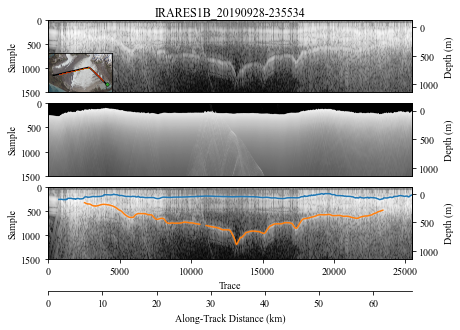

In [12]:
# plot with sample and trace axis labels
fig, ax = plt.subplots(3, figsize=(6.5,4.5))
fig.suptitle(track.rstrip(".h5"))

ax[0].imshow(rdata.proc.get_curr_dB(), aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)
ax[0].set_ylabel("Sample")
ax[0].set_xlim(0, tr-tl)

# ax[0].set_xlim(tl, tr)
ax[0].set_ylim(sb, st)
ax[0].get_xaxis().set_visible(False)
secaxy = ax[0].twinx()
secaxy.yaxis.set_ticks_position("right")
secaxy.yaxis.set_label_position("right")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])

ax[1].imshow(rdata.sim,  aspect="auto", extent=extent, cmap=cmap, vmin=vsmin, vmax=vsmax)
ax[1].set_ylabel("Sample")
ax[1].set_xlim(0, tr-tl)

# ax[1].set_xlim(tl, tr)
ax[1].set_ylim(sb, st)
ax[1].get_xaxis().set_visible(False)
secaxy = ax[1].twinx()
secaxy.yaxis.set_ticks_position("right")
secaxy.yaxis.set_label_position("right")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])

ax[2].imshow(rdata.proc.get_curr_dB(),  aspect="auto", extent=extent, cmap=cmap, vmin=vdmin, vmax=vdmax)
ax[2].set_xlabel("Trace")
ax[2].set_ylabel("Sample")
ax[2].set_xlim(0, tr-tl)

# ax[2].set_xlim(tl, tr)
ax[2].set_ylim(sb, st)
ax[2].plot(np.roll(srf_samps,-tl),c='tab:blue')
ax[2].plot(np.roll(bed_samps,-tl),c='tab:orange')

secaxy = ax[2].twinx()
secaxy.yaxis.set_ticks_position("right")
secaxy.yaxis.set_label_position("right")
secaxy.set_ylim(utils.twtt2depth((sb - y_depth_s0) * rdata.dt),
                -1*utils.twtt2depth(y_depth_s0 * rdata.dt))
secaxy.set_ylabel("Depth (m)")
secaxy.set_yticks([0,500,1000])
secaxx = ax[2].twiny()
secaxx.xaxis.set_ticks_position("bottom")
secaxx.xaxis.set_label_position("bottom")
secaxx.spines["bottom"].set_position(("outward", 32.5))
secaxx.set_xlim(0, rdata.navdf["dist"].iloc[tr-1]*1e-3 - rdata.navdf["dist"].iloc[tl]*1e-3)
secaxx.set_xlabel("Along-Track Distance (km)")

# basemap inset
lon = rdata.navdf.lon.values[tl:tr]
lat = rdata.navdf.lat.values[tl:tr]
lon_filt = rdata.navdf.lon[~np.isnan(bed_samps)]
lat_filt = rdata.navdf.lat[~np.isnan(bed_samps)]
# ins = fig.add_axes([0.775, 0, 0.2, 0.2])
# ins = ax[0].inset_axes([0.85,0,0.15,0.5])
ins = ax[0].inset_axes([0,0,0.175,0.55])
bm_im = ins.imshow(np.ones((100,100)), aspect="auto", extent = [_i for _i in[dataset.bounds.left, dataset.bounds.right,
                dataset.bounds.bottom, dataset.bounds.top]])
bm_im.set_clim([cmin, cmax])
bm_im.set_data(im)
ins.plot(lon, lat,"k",linewidth=1.5)
ins.scatter(lon[0],lat[0], c='tab:green',s=50, marker='.', edgecolors='k', linewidth=0.5, zorder=10000)
ins.scatter(lon_filt,lat_filt, c='tab:orange', s=1e-4, marker='.', zorder=10000)
ins.set_xlim([rdata.navdf.lon[tr-1]-.1, rdata.navdf.lon[tl]+.1])
ins.set_ylim([59.75, 60.15])
ins.get_xaxis().set_visible(False)
ins.get_yaxis().set_visible(False)


fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.15, bottom=.2, top=.9375)

In [13]:
fig.savefig('C:/Users/btober/OneDrive - University of Arizona/Documents/pres/mala/figs/2021/' + track.rstrip('.h5') + '_clut.png', dpi=400)